# Sequence Models in Tensorflow

In this notebook, we'll build a very basic sequence model using a (not very) deep neural net. It should run on a semi-powerful laptop without GPU support, but no promises...

Helpful links:

* [Tensorflow 2.0 Docs](https://www.tensorflow.org/beta)
* [Seq2Seq in Tensorflow 2.0](https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/)
* [Transformer in Tensorflow 2.0](https://machinetalk.org/2019/04/29/create-the-transformer-with-tensorflow-2-0/)

## Background

* Generating Sequences
* Baselining against a Vanilla CNN
* Sequence models
* Seq2Seq
* Transformer

## Imports

Import core libraries and make sure tensorflow is working

In [1]:
# Standard lib
import itertools

# 3rd party libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
assert tf.__version__.startswith('2.')

In [2]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
GPU is NOT AVAILABLE


## CpG Island Model

Let's compare these sequence models to the CpG island HMM predictor from two weeks ago

Here's the sequence from last time:

In [3]:
seq = 'AGAACTGCTGACTGATAGATCGCGCGCCGCGCGCGCGGCATGCATCGATGCATGCGCAACTCGAATCGATTGACAGAAGACAATTATGACAATGCGCAGCAGCATTTATTACTACACATACGGTGCACTGCGCGCGCTCACTGCA'

In [4]:
seq_dict = {'A': 0, 'T': 1, 'G': 2, 'C': 3}

In [5]:
obs_seq = np.array([seq_dict[s] for s in seq])
obs_seq

array([0, 2, 0, 0, 3, 1, 2, 3, 1, 2, 0, 3, 1, 2, 0, 1, 0, 2, 0, 1, 3, 2,
       3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 0, 1, 2, 3, 0,
       1, 3, 2, 0, 1, 2, 3, 0, 1, 2, 3, 2, 3, 0, 0, 3, 1, 3, 2, 0, 0, 1,
       3, 2, 0, 1, 1, 2, 0, 3, 0, 2, 0, 0, 2, 0, 3, 0, 0, 1, 1, 0, 1, 2,
       0, 3, 0, 0, 1, 2, 3, 2, 3, 0, 2, 3, 0, 2, 3, 0, 1, 1, 1, 0, 1, 1,
       0, 3, 1, 0, 3, 0, 3, 0, 1, 0, 3, 2, 2, 1, 2, 3, 0, 3, 1, 2, 3, 2,
       3, 2, 3, 2, 3, 1, 3, 0, 3, 1, 2, 3, 0])

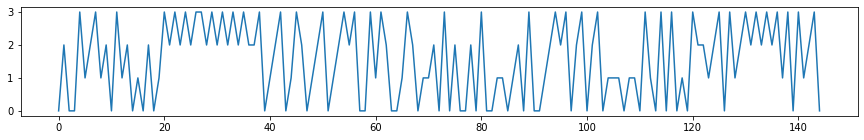

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(obs_seq);

## Model 0: HMM

Here's the HMM model from last time

In [7]:
emissions = np.ones((2, 4))
emissions[0, :] = 0.25
emissions[1, :2] = 0.1
emissions[1, 2:] = 0.4

# Make sure our emission matrix is a probability matrix
assert np.all(np.abs(np.sum(emissions, axis=1) - 1.0) < 1e-5)

emissions

array([[0.25, 0.25, 0.25, 0.25],
       [0.1 , 0.1 , 0.4 , 0.4 ]])

In [8]:
transitions = np.ones((2, 2))
transitions[0, 0] = 0.9
transitions[0, 1] = 0.1
transitions[1, 0] = 0.05
transitions[1, 1] = 0.95

# Make sure our transition matrix is a probability matrix
assert np.all(np.abs(np.sum(transitions, axis=1) - 1.0) < 1e-5)

transitions

array([[0.9 , 0.1 ],
       [0.05, 0.95]])

Use the HMM to predict the best states

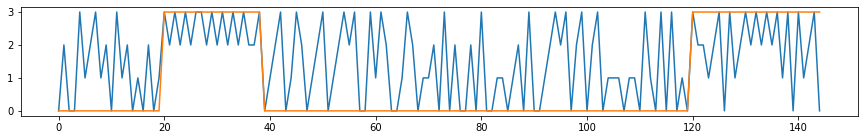

In [9]:
def viterbi(x, transmat, emissions):
    v_seq = np.zeros((len(x), len(transmat)))
    states = np.zeros((len(x), len(transmat)))
    best_states = np.zeros(len(x),  dtype=int)
    for i in range(len(v_seq)):
        if i == 0:
            v_seq[0] = (1/len(transmat)) * emissions[:,x[i]]
            v_seq[0] = np.log(v_seq[0])
            states[0] = np.zeros(len(transmat))
            continue
        p = v_seq[i-1] + np.log(transmat.T)
        states[i] =  np.argmax(p, axis=1)
        v_seq[i] =   np.log(emissions[:,x[i]]) + np.amax(p, axis = 1)
        
    best_states[-1] = np.argmax(v_seq[-1])
    
    for i in reversed(range(1, len(x))):
        best_states[i-1] = states[i][best_states[i]]
        
    return v_seq, states, best_states

v_seq, states, best_states = viterbi(obs_seq, transitions, emissions)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(obs_seq)
ax.plot(best_states*3);

## Using the HMM to generate training data

Since the HMM is a generative model, let's use it to generate a training data set

In [10]:
def sample_hmm(x_len: int = 128):
    """ Sample the hidden markov model
    
    For this tutorial, make all the sequences a power of two
    
    :param int x_len:
        Length of the sequence to sample
    """
    emission_states = np.arange(emissions.shape[1])
    transition_states = np.arange(transitions.shape[1])

    # Guess initial state random
    states = [np.random.choice(transition_states, p=np.array([0.5, 0.5]))]
    values = []
    
    # Now step through and draw samples according to the model
    for i in range(x_len):
        cur_state = states[i]
        emission_prob = emissions[cur_state, :]
        transition_prob = transitions[cur_state, :]
        values.append(np.random.choice(emission_states, p=emission_prob))
        states.append(np.random.choice(transition_states, p=transition_prob))
    return np.array(states[:-1]), np.array(values)


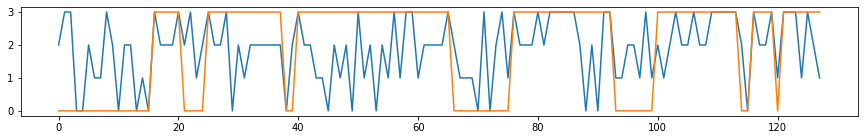

In [11]:
states, values = sample_hmm()

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(values)
ax.plot(states*3);

This does show a limitation of this simple HMM: it generates sequences that don't really look like real sequences. We could probably do better if our HMM was more tuned or we had a model with a more complicated structure.

On the other hand, it provides a nice data set with clear ground truth, so lets just go forward with it.

## Training Data: HMM generated samples

Generate 1000 samples and split them into train/test/validation

In [12]:
# Set the random seed here
np.random.seed(12345)

# Generate 1000 samples
x_data, y_data = [], []
for _ in range(1000):
    states, values = sample_hmm()
    x_data.append(values)
    y_data.append(states)

# Split into train/test/validation
x_train, y_train = x_data[:800], y_data[:800]
x_test, y_test = x_data[800:900], y_data[800:900]
x_valid, y_valid = x_data[900:], y_data[900:]

Do the samples in each bucket look similar?

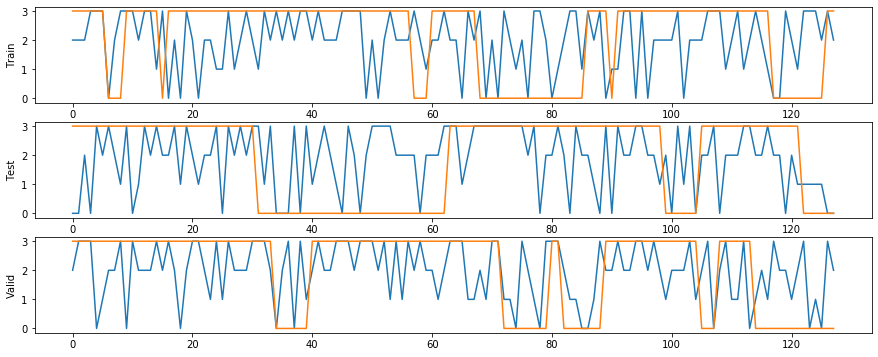

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6))
ax1.plot(x_train[0])
ax1.plot(y_train[0]*3)
ax1.set_ylabel('Train')

ax2.plot(x_test[1])
ax2.plot(y_test[1]*3)
ax2.set_ylabel('Test')

ax3.plot(x_valid[2])
ax3.plot(y_valid[2]*3)
ax3.set_ylabel('Valid');

## Model 1: Convolutional Neural Net

Before diving into sequence models, lets look at how hard it would be to model this data with a simpler architecture: a Convolutional Neural Net.

Quick reminder about convolutions (thanks Wikipedia):

![1D Convolution](images/Convolution_of_box_signal_with_itself2.gif)

First question, how wide are our islands, on average:

In [14]:
# Find the lengths of all the runs in the data
island_lengths = [sum(g) for y in y_train for b, g in itertools.groupby(y) if b == 1]

# zero-D Bar plot
print('Min length:    {:0.2f}'.format(np.min(island_lengths)))
print('Max length:    {:0.2f}'.format(np.max(island_lengths)))
print('Mean length:   {:0.2f}'.format(np.mean(island_lengths)))
print('Std length:    {:0.2f}'.format(np.std(island_lengths)))

Min length:    1.00
Max length:    120.00
Mean length:   17.57
Std length:    16.48


In [15]:
# zero-D Box plot
print('5%  length:    {:0.2f}'.format(np.percentile(island_lengths, 5)))
print('25% length:    {:0.2f}'.format(np.percentile(island_lengths, 25)))
print('Median length: {:0.2f}'.format(np.median(island_lengths)))
print('75% length:    {:0.2f}'.format(np.percentile(island_lengths, 75)))
print('95% length:    {:0.2f}'.format(np.percentile(island_lengths, 95)))

5%  length:    1.00
25% length:    6.00
Median length: 13.00
75% length:    24.00
95% length:    51.00


So, with a field of view of only 51 characters, we can cover 95% of all "CpG" islands. Let's try a classic hourglass architecture 32-characters wide:

* 32 x 4 character input FOV
* 16 x 8 characters
* 8 x 8 characters
* 16 x 4 characters
* 32 x 1 character output FOV

First though, we need to embed the sequences in one-hot encoding space

In [35]:
def one_hot_encoding(x_train, num_classes=4):
    """ One hot encode the character vector """
    return np.eye(num_classes)[x_train.reshape(-1)]

What does one hot encoding look like?

In [34]:
print(x_train[0][:10])
print(one_hot_encoding(x_train[0])[:10].T)

[2 2 2 3 3 3 0 2 3 3]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 1.]]


In [36]:
# Encode all our samples this way
x_train_enc = [one_hot_encoding(x) for x in x_train]
x_test_enc = [one_hot_encoding(x) for x in x_test]
x_valid_enc = [one_hot_encoding(x) for x in x_valid]

## Model 1: CNN Network Architecture

What does a basic convolutional neural network look like in a sequence context?

In [18]:
# Pull out the various layer types from keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten
from tensorflow.keras.models import Model

# Embed a 4-level input into a 4 dimensional output (one hot encoding)
# Note that since this model is convolutional, input can be any multiple of 32 bases
input_net = net = Input(shape=(128, 4))

# 32x8
net = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(net)

# 16x16
net = MaxPooling1D(pool_size=2)(net)
net = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(net)

# 8x32
net = MaxPooling1D(pool_size=2)(net)
net = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(net)

# 16x16
net = UpSampling1D(2)(net)
net = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(net)

# 32x1
net = UpSampling1D(2)(net)
net = Conv1D(filters=1, kernel_size=3, activation='relu', padding='same')(net)

# Read out the score
model = Model(inputs=input_net, outputs=net)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Now we should visualize the model to make sure all the layers make sense and everything is connected the way we think it should be.

In [31]:
# Summary to check the layer shapes
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 8)            104       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 16)            400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 32)            1568      
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 64, 32)            0     

Once the model gets too large, it's hard to visualize this way. We can plot it instead

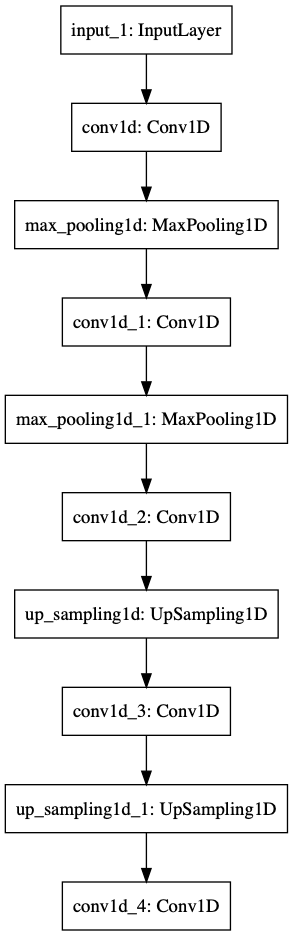

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(model)

## Model 1: Training the CNN

This model trains for about 200 epochs before saturating at 0.45ish loss... not too bad for a small and very cheesy neural net.

We could improve this with more data, a better architecture, or by fiddling with the loss and optimizer hyperparameters

In [21]:
# This takes about 30 seconds on my laptop
model.fit(x=np.array(x_train_enc), y=np.array(y_train), batch_size=100, epochs=200);

Train on 800 samples
Epoch 1/200
800/800 [==============================] - 1s 1ms/sample - loss: 2.6309
Epoch 2/200
800/800 [==============================] - 0s 159us/sample - loss: 0.8792
Epoch 3/200
800/800 [==============================] - 0s 148us/sample - loss: 0.7114
Epoch 4/200
800/800 [==============================] - 0s 149us/sample - loss: 0.7017
Epoch 5/200
800/800 [==============================] - 0s 147us/sample - loss: 0.6731
Epoch 6/200
800/800 [==============================] - 0s 149us/sample - loss: 0.6625
Epoch 7/200
800/800 [==============================] - 0s 155us/sample - loss: 0.6459
Epoch 8/200
800/800 [==============================] - 0s 154us/sample - loss: 0.6267
Epoch 9/200
800/800 [==============================] - 0s 148us/sample - loss: 0.6113
Epoch 10/200
800/800 [==============================] - 0s 149us/sample - loss: 0.6234
Epoch 11/200
800/800 [==============================] - 0s 148us/sample - loss: 0.5988
Epoch 12/200
800/800 [===========

800/800 [==============================] - 0s 144us/sample - loss: 0.4695
Epoch 96/200
800/800 [==============================] - 0s 142us/sample - loss: 0.4688
Epoch 97/200
800/800 [==============================] - 0s 143us/sample - loss: 0.4685
Epoch 98/200
800/800 [==============================] - 0s 150us/sample - loss: 0.4683
Epoch 99/200
800/800 [==============================] - 0s 143us/sample - loss: 0.4683
Epoch 100/200
800/800 [==============================] - 0s 146us/sample - loss: 0.4695
Epoch 101/200
800/800 [==============================] - 0s 146us/sample - loss: 0.4677
Epoch 102/200
800/800 [==============================] - 0s 150us/sample - loss: 0.4679
Epoch 103/200
800/800 [==============================] - 0s 144us/sample - loss: 0.4674
Epoch 104/200
800/800 [==============================] - 0s 141us/sample - loss: 0.4679
Epoch 105/200
800/800 [==============================] - 0s 141us/sample - loss: 0.4670
Epoch 106/200
800/800 [===========================

800/800 [==============================] - 0s 145us/sample - loss: 0.4555
Epoch 189/200
800/800 [==============================] - 0s 146us/sample - loss: 0.4545
Epoch 190/200
800/800 [==============================] - 0s 148us/sample - loss: 0.4536
Epoch 191/200
800/800 [==============================] - 0s 143us/sample - loss: 0.4532
Epoch 192/200
800/800 [==============================] - 0s 142us/sample - loss: 0.4529
Epoch 193/200
800/800 [==============================] - 0s 139us/sample - loss: 0.4530
Epoch 194/200
800/800 [==============================] - 0s 145us/sample - loss: 0.4529
Epoch 195/200
800/800 [==============================] - 0s 146us/sample - loss: 0.4524
Epoch 196/200
800/800 [==============================] - 0s 140us/sample - loss: 0.4520
Epoch 197/200
800/800 [==============================] - 0s 143us/sample - loss: 0.4533
Epoch 198/200
800/800 [==============================] - 0s 140us/sample - loss: 0.4543
Epoch 199/200
800/800 [=======================

## Model 1: CNN Evalutation

How well does our basic CNN do?

In [22]:
y_hat = model.predict(np.array(x_test_enc))

Look at some sample traces and compare to our HMM "ground truth"

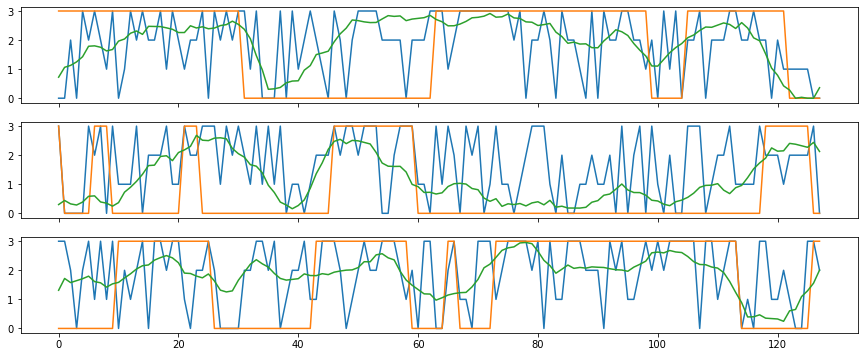

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

ax1.plot(x_test[1])
ax1.plot(y_test[1]*3)
ax1.plot(y_hat[1]*3);

ax2.plot(x_test[2])
ax2.plot(y_test[2]*3)
ax2.plot(y_hat[2]*3);

ax3.plot(x_test[3])
ax3.plot(y_test[3]*3)
ax3.plot(y_hat[3]*3);


So it's obviously learned something... basically it predicts high when it sees a run of C's and G's

In [26]:
print('Model 1 loss: {:0.4f}'.format(model.evaluate(np.array(x_test_enc), np.array(y_test),
                                                    verbose=0)))

Model 1 loss: 0.4652


How does it do on our one real sample?

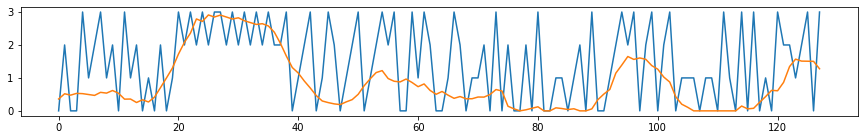

In [30]:
y_pred = model.predict(np.array(one_hot_encoding(obs_seq[:128]))[np.newaxis, ...])

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(obs_seq[:128])
ax.plot(y_pred.ravel()*3);

... not too bad for the first CpG, less good (but not horrible) for the more questionable second. Can we do better?

## Sequence Models

So the CNN scheme actually seems to work okay, but maybe we can do better. CNNs are stateless, so they can only understand the field of view that they can see. You can see this effect in the start of the CpG island, where the probability takes several bases to "wind up".

Recurrent layers have "memory" because they recieve a copy of the previous output on their input, so they can keep previous state.

There are a bunch of recurrent schemes that you can see in the [Recurrent Layers](https://keras.io/layers/recurrent/)

### Simple RNN

Previous output gets fed in with the input, fully connected layer. No one really uses these... [Wiki](https://en.wikipedia.org/wiki/Recurrent_neural_network)

![Simple RNN](images/RNN.png)

### Gated Recurrent Unit (GRU)

Kind of like a flip flop with a clear signal. I don't usually see these get used but they seem neat. [Wiki](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

![GRU](images/GRU.png)

See: Cho, Kyunghyun; van Merrienboer, Bart; Gulcehre, Caglar; Bahdanau, Dzmitry; Bougares, Fethi; Schwenk, Holger; Bengio, Yoshua (2014). "Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation"

### Long Short-Term Memory (LSTM)

Something like a modern memory cell. Everyone uses these. [Wiki](https://en.wikipedia.org/wiki/Long_short-term_memory)

![LSTM](images/LSTM.png)

See: Sepp Hochreiter; Jürgen Schmidhuber (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780

## Model 2: Baby RNN

This is a toy model given in the keras docs as [Baby RNN](https://keras.io/examples/babi_rnn/), modified to work on our CpG dataset.

Notice that Keras implements all the internal complexity of an LSTM in a single layer class. This is why Keras is awesome.


In [83]:
# Pull out the various layer types from keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Excercise to the reader, change this to a different layer block and see what happens
RNN = layers.LSTM

SENT_HIDDEN_SIZE = 100
BATCH_SIZE = 200
EPOCHS = 100

input_maxlen = 64
query_maxlen = 64
vocab_size = 4

# Seq-to-seq like construction, predict the CpG score given the previous CpG call
sentence = layers.Input(shape=(input_maxlen, vocab_size))
encoded_sentence = RNN(SENT_HIDDEN_SIZE)(sentence)

# Now we'll fit a couple of dense layers on top of the LSTM to try and convert from encoded state to score
preds = layers.Dense(query_maxlen, activation='relu')(encoded_sentence)
preds = layers.Dense(query_maxlen, activation='relu')(preds)

model = Model(sentence, preds)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

What does this model look like?

In [84]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 64, 4)]           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
Total params: 52,624
Trainable params: 52,624
Non-trainable params: 0
_________________________________________________________________


So, much simpler in some senses, much more complex in others

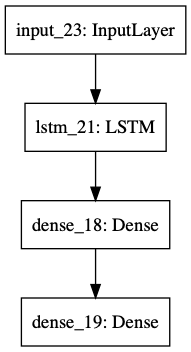

In [85]:
plot_model(model)

In [86]:
# For a real model, we would use padding, but for this just truncate
x_sequence = np.array([x[:input_maxlen] for x in x_train_enc])
y_result = np.array([y[:query_maxlen] for y in y_train])

# Fit the model on these sequence fragments
# This takes about 2 minutes on my laptop
model.fit([x_sequence], y_result,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Train on 800 samples
Epoch 1/100
800/800 [==============================] - 2s 3ms/sample - loss: 5.8268 - accuracy: 0.3507
Epoch 2/100
800/800 [==============================] - 1s 626us/sample - loss: 5.0158 - accuracy: 0.3507
Epoch 3/100
800/800 [==============================] - 1s 639us/sample - loss: 4.6560 - accuracy: 0.3507
Epoch 4/100
800/800 [==============================] - 0s 616us/sample - loss: 4.3702 - accuracy: 0.3507
Epoch 5/100
800/800 [==============================] - 1s 627us/sample - loss: 4.0331 - accuracy: 0.3507
Epoch 6/100
800/800 [==============================] - 1s 628us/sample - loss: 3.7014 - accuracy: 0.3507
Epoch 7/100
800/800 [==============================] - 1s 647us/sample - loss: 3.4695 - accuracy: 0.3507
Epoch 8/100
800/800 [==============================] - 1s 648us/sample - loss: 3.2679 - accuracy: 0.3510
Epoch 9/100
800/800 [==============================] - 1s 647us/sample - loss: 2.9508 - accuracy: 0.3522
Epoch 10/100
800/800 [==============

800/800 [==============================] - 1s 641us/sample - loss: 1.7099 - accuracy: 0.6389
Epoch 79/100
800/800 [==============================] - 0s 609us/sample - loss: 1.7064 - accuracy: 0.6422
Epoch 80/100
800/800 [==============================] - 0s 605us/sample - loss: 1.7061 - accuracy: 0.6420
Epoch 81/100
800/800 [==============================] - 1s 630us/sample - loss: 1.7040 - accuracy: 0.6450
Epoch 82/100
800/800 [==============================] - 1s 632us/sample - loss: 1.7031 - accuracy: 0.6443
Epoch 83/100
800/800 [==============================] - 0s 612us/sample - loss: 1.7028 - accuracy: 0.6447
Epoch 84/100
800/800 [==============================] - 1s 626us/sample - loss: 1.7019 - accuracy: 0.6450
Epoch 85/100
800/800 [==============================] - 1s 627us/sample - loss: 1.7016 - accuracy: 0.6452
Epoch 86/100
800/800 [==============================] - 1s 628us/sample - loss: 1.7007 - accuracy: 0.6459
Epoch 87/100
800/800 [==============================] - 0s 

Well that sucks! How does it look on the test data?

In [91]:
model.evaluate(np.array([x[:input_maxlen] for x in x_test_enc]),
               np.array([y[:input_maxlen] for y in y_test]))

y_hat1 = model.predict(np.array([x[:input_maxlen] for x in x_test_enc]))
y_hat2 = model.predict(np.array([x[input_maxlen:] for x in x_test_enc]))

y_hat = np.concatenate([y_hat1, y_hat2], axis=-1)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

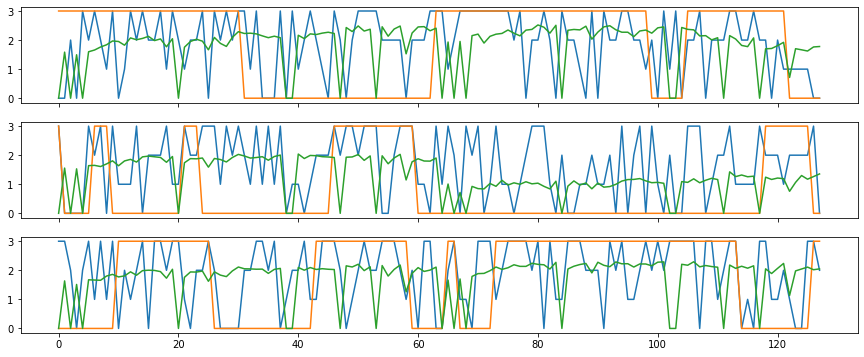

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

ax1.plot(x_test[1])
ax1.plot(y_test[1]*3)
ax1.plot(y_hat[1]*3);

ax2.plot(x_test[2])
ax2.plot(y_test[2]*3)
ax2.plot(y_hat[2]*3);

ax3.plot(x_test[3])
ax3.plot(y_test[3]*3)
ax3.plot(y_hat[3]*3);


So maybe it's learned something about non-GC content? It seems pretty random to me though...

What about our real sequence?

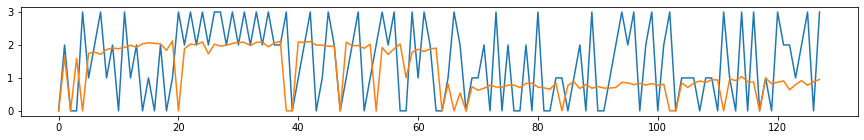

In [92]:
y_pred1 = model.predict(np.array(one_hot_encoding(obs_seq[:input_maxlen]))[np.newaxis, ...])
y_pred2 = model.predict(np.array(one_hot_encoding(obs_seq[64:128]))[np.newaxis, ...])

y_pred = np.concatenate([y_pred1, y_pred2], axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(obs_seq[:128])
ax.plot(y_pred.ravel()*3);

... not great. It seems underfit, but we don't have the cycles to push it more.

## Model 2.5: Baby RNN with Seq-to-Seq

Now we are going to try and steal a technique from the [Seq-to-Seq](https://arxiv.org/abs/1409.3215) paper.

Instead of just feeding in the input and expecting the score, we'll feed in the input **AND** the score (offset by one step in time) and see if the model can learn just the time shift.

In [161]:
# Pull out the various layer types from keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Excercise to the reader, change this to a different layer block and see what happens
RNN = layers.LSTM

SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 200
EPOCHS = 100

input_maxlen = 64
query_maxlen = 64
vocab_size = 4

# Seq-to-seq like construction, predict the CpG score given the previous CpG call
sentence = layers.Input(shape=(input_maxlen, vocab_size))
sentence_encoder = RNN(SENT_HIDDEN_SIZE)
encoded_sentence = sentence_encoder(sentence)

question = layers.Input(shape=(query_maxlen, 1))
question_encoder = RNN(QUERY_HIDDEN_SIZE)
encoded_question = question_encoder(question)

merged = layers.concatenate([encoded_sentence, encoded_question])
dense_layer = layers.Dense(query_maxlen, activation='relu')
dense = dense_layer(merged)
pred_layer = layers.Dense(query_maxlen, activation='relu')
preds = pred_layer(dense)

model = Model([sentence, question], preds)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

What does this model look like?

In [162]:
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 64, 4)]      0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 64, 1)]      0                                            
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 100)          42000       input_40[0][0]                   
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 100)          40800       input_41[0][0]                   
___________________________________________________________________________________________

Now you can see the two input streams as branches.

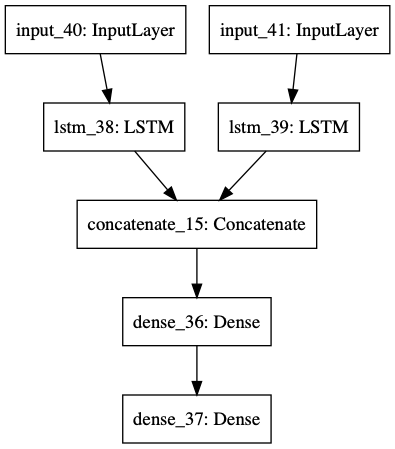

In [163]:
plot_model(model)

In [164]:
# For a real model, we would use padding
x_sequence = np.array([x[:input_maxlen] for x in x_train_enc])
x_query = np.array([y[:query_maxlen, np.newaxis] for y in y_train])
y_result = np.array([y[1:query_maxlen+1] for y in y_train])

# Fit the model on these sequence fragments
# This takes about 2 minutes on my laptop
model.fit([x_sequence, x_query], y_result,
          batch_size=BATCH_SIZE,
          epochs=20)

Train on 800 samples
Epoch 1/20
800/800 [==============================] - 4s 5ms/sample - loss: 5.5344 - accuracy: 0.3484
Epoch 2/20
800/800 [==============================] - 1s 977us/sample - loss: 4.2556 - accuracy: 0.3484
Epoch 3/20
800/800 [==============================] - 1s 967us/sample - loss: 3.5495 - accuracy: 0.3484
Epoch 4/20
800/800 [==============================] - 1s 960us/sample - loss: 3.2827 - accuracy: 0.3491
Epoch 5/20
800/800 [==============================] - 1s 950us/sample - loss: 3.0299 - accuracy: 0.3546
Epoch 6/20
800/800 [==============================] - 1s 1ms/sample - loss: 2.8323 - accuracy: 0.3981
Epoch 7/20
800/800 [==============================] - 1s 981us/sample - loss: 2.6240 - accuracy: 0.4647
Epoch 8/20
800/800 [==============================] - 1s 962us/sample - loss: 2.5019 - accuracy: 0.5260
Epoch 9/20
800/800 [==============================] - 1s 986us/sample - loss: 2.3541 - accuracy: 0.5254
Epoch 10/20
800/800 [==========================

Better!? Predicting is now a little tricky, because we need to feed the model back it's own values in a loop

In [181]:
def predict(x_enc, y_enc):
    # Initialize the LSTM states
    x_state_h, x_state_c = tf.zeros([1, SENT_HIDDEN_SIZE]), tf.zeros([1, SENT_HIDDEN_SIZE])
    y_state_h, y_state_c = tf.zeros([1, QUERY_HIDDEN_SIZE]), tf.zeros([1, QUERY_HIDDEN_SIZE])
    
    sentence_encoder.return_state = True
    question_encoder.return_state = True
    
    # Seed y with inital values (typically this would be a special start token, and we would fill in)
    y_seed = list(y_enc[:query_maxlen])
    for i in range(x_enc.shape[0] - input_maxlen):
        x_raw = x_enc[i:i+input_maxlen].astype(np.float32)
        y_raw = np.array(y_seed[i:i+query_maxlen]).astype(np.float32)[..., np.newaxis]
        
        x_in = tf.constant([x_raw])
        y_in = tf.constant([y_raw])   
        
        x_out, x_state_h, x_state_c = sentence_encoder(x_in, (x_state_h, x_state_c))
        y_out, y_state_h, y_state_c = question_encoder(y_in, (y_state_h, y_state_c))
        
        # Map this through the rest of the net
        z1 = layers.concatenate([x_out, y_out])
        z2 = dense_layer(z1)
        y = pred_layer(z2)
        
        y_seed.append(float(y[0, -1]))
        
    return np.array(y_seed)

In [183]:
# Notice how much slower this is...
y_pred1 = predict(x_test_enc[0], y_test[0])
y_pred2 = predict(x_test_enc[1], y_test[1])
y_pred3 = predict(x_test_enc[2], y_test[2])


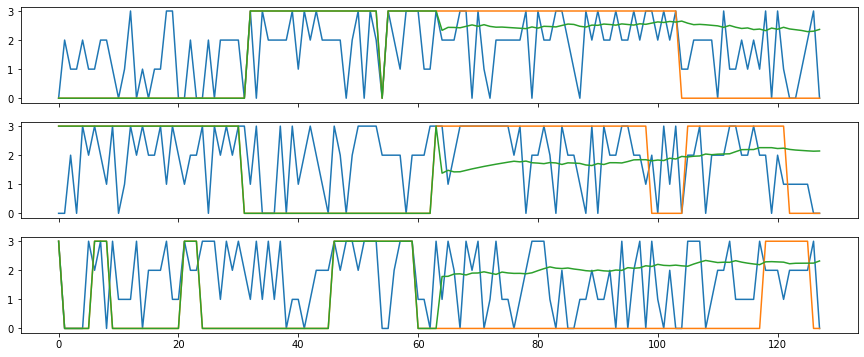

In [185]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

ax1.plot(x_test[0])
ax1.plot(y_test[0]*3)
ax1.plot(y_pred1*3);

ax2.plot(x_test[1])
ax2.plot(y_test[1]*3)
ax2.plot(y_pred2*3);

ax3.plot(x_test[2])
ax3.plot(y_test[2]*3)
ax3.plot(y_pred3*3);

## Model 3: Seq-to-Seq

[Seq-to-Seq in TF2](https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/)

Coming soon!

## Model 4: Transformer

[Transformer in TF2](https://machinetalk.org/2019/04/29/create-the-transformer-with-tensorflow-2-0/)

Coming soon!